In [11]:
# Created January 4, 2021
# Updated January 7, 2021

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
if True:
    mpl.rcParams['lines.linewidth'] = 0.75
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.05
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['xtick.major.pad'] = 2
    mpl.rcParams['xtick.minor.pad'] = 1.5
    mpl.rcParams['ytick.major.pad'] = 2
    mpl.rcParams['ytick.minor.pad'] = 1.5
    mpl.rcParams['figure.facecolor'] = (1,1,1,1) #white
    mpl.rcParams['figure.edgecolor'] = (1,1,1,1) #white
    mpl.rcParams['axes.titlesize'] = 10
    mpl.rcParams['legend.fontsize'] = 6
    mpl.rcParams['axes.labelpad'] = 0

import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

blues = mpl.cm.get_cmap('Blues')
reds = mpl.cm.get_cmap('Reds')

import methods.filter_lineages as fl
import pickle

In [12]:
for bac in BACTERIA:
    z = len(fl.bac_gene_meta_dict[bac].keys())
    print(len(set(list(fl.wu_genes[bac]['HF']['del']+list(fl.wu_genes[bac]['LF']['del'])))) / z )

0.16602739726027396
0.18228105906313646
0.12641272498953537
0.304870834154999


In [19]:
# bac, bc = 'BtVPI', 'HL'
# norm = mpl.colors.LogNorm( 1, 3e3 )

# with open('muller_lineages.pkl', 'rb') as f:
#     muller_lineage_dict = pickle.load(f)

def plot_lfc_heat_map(ax, lfcs1, lfcs2, norm=None, binspace=None, cmap=blues, colorbar=True):
    where_finite = (lfcs1.mask + lfcs2.mask == 0)

    if not np.any(binspace):
        binspace = np.linspace(-1., 1, 41)

    density, binx, biny = np.histogram2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace)

    if not norm:
        norm = mpl.colors.LogNorm( 1, np.max(density) )

    ## plot empirical
    ax.hist2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace, cmap=cmap, norm=norm)

    # r, pval = scipy.stats.pearsonr(lfcs1[where_finite], lfcs2[where_finite])
    ax.axvline(0, color='black', linestyle='dashed', zorder=5)
    ax.axhline(0, color='black', linestyle='dashed', zorder=5)
    # ax.text(0.1, 0.9, f'r={r:.2f}', transform=ax.transAxes, color='black')

    if colorbar:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

def plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple,
                               norm=mpl.colors.LogNorm(0.1, 3e3),
                               colorbar=False, cmap=mpl.cm.Reds,
                               minfreq=10**-6.5, plot_muller=False):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple

    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > minfreq

    m1_reads1, m1_reads2 = fl.get_read_arrays(bac, m1, m1t1, m1t2, split_day0=2)
    m2_reads1, m2_reads2 = fl.get_read_arrays(bac, m2, m2t1, m2t2, split_day0=1)
    m1_D1, m1_D2 = m1_reads1.sum(), m1_reads2.sum()
    m2_D1, m2_D2 = m2_reads1.sum(), m2_reads2.sum()
    m1_freqs1, m1_freqs2 = m1_reads1 / m1_D1, m1_reads2 / m1_D2
    m2_freqs1, m2_freqs2 = m2_reads1 / m2_D1, m2_reads2 / m2_D2

    m1_f1, m1_f2 = fl.maxmin_freqs(m1_freqs1, m1_D1, m1_freqs2, m1_D2)
    m2_f1, m2_f2 = fl.maxmin_freqs(m2_freqs1, m2_D1, m2_freqs2, m2_D2)

    m1_lfcs = fl.calc_lfc_array( m1_f1, m1_f2, m1t2-m1t1)
    m2_lfcs = fl.calc_lfc_array( m2_f1, m2_f2, m2t2-m2t1)

    binspace = np.linspace(np.min([m1_lfcs,m2_lfcs]), np.max([m1_lfcs, m2_lfcs]), 41)
    # binspace = [ np.linspace(-np.log(1/epsilon)/dt1 -1/100, np.log(1/epsilon)/dt1 + 1/100, 41),
    #              np.linspace(-np.log(1/epsilon)/dt2 -1/100, np.log(1/epsilon)/dt2 + 1/100, 41)]

    plot_lfc_heat_map(ax, m1_lfcs[lineage_bool], m2_lfcs[lineage_bool], norm=norm, binspace=binspace, colorbar=colorbar, cmap=cmap)

    if plot_muller:
        # for diet, s in [('HF', 30), ('LF', 30), ('HLH', 10), ('LHL', 10)]:
        ax.set_xlim(-1.0, 0.8)
        ax.set_ylim(-1.0, 1.2)
        ax.set_xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
        ax.set_yticks([-0.8, -0.4, 0.0, 0.4, 0.8, 1.2])
        fig.savefig(f'fig3_nostars.pdf')
        for diet, marker in [('HF', (3,0,-90)), ('LF', (3,0,0)), ('HLH', (3,0,-45)), ('LHL', (3,0,-45))]:
            muller_lineages = muller_lineage_dict[bac][diet]


            m1_star_lfcs = m1_lfcs[muller_lineages]
            m2_star_lfcs = m2_lfcs[muller_lineages]

            # ax.scatter(m1_star_lfcs, m2_star_lfcs, color=DIET_COLORS[diet], facecolors='none', marker='*', s=s, zorder=20)
            ax.scatter(m1_star_lfcs, m2_star_lfcs, color=DIET_COLORS[diet], marker=marker, s=25, zorder=20)
            fig.savefig(f'fig3_stars_{diet}.pdf')
# diet_colors = {'HF':'red', 'LF':'blue', 'HLH':'orange', 'LHL':'purple'}
#
# def make_fit_barcode_gene_points(bac, bc, sorted_indices, mice, t0, t1):
#     """ Assuming single mouse """
#     barcode_positions = barcodes[bac][bc]
#     position_to_index_map = {pos: i for i, pos in enumerate(barcode_positions)}
#
#     sorted_positions = barcode_positions[sorted_indices]
#
#     coarse_grained_lfc = []
#
#     mice_freqs_t0 = freq_dict[bac][bc][ [MX[(mouse, t0)] for mouse in mice] ]
#     mice_freqs_t1 = freq_dict[bac][bc][ [MX[(mouse, t1)] for mouse in mice] ]
#
#     for i in range(len(sorted_indices)):
#         try:
#             gene = barcode_gene_dict[bac][sorted_positions[i]][0]
#             gene_bc_positions = set(gene_barcode_dict[bac][gene][1])
#             gene_bc_indices = [ position_to_index_map[pos] for pos in gene_bc_positions ]
#         except:
#             coarse_grained_lfc.append(0)
#             continue
#
#         cg_gene_t0 = mice_freqs_t0[:, gene_bc_indices].sum(axis=1) - mice_freqs_t0[:, sorted_indices[i]]
#         cg_gene_t1 = mice_freqs_t1[:, gene_bc_indices].sum(axis=1) - mice_freqs_t1[:, sorted_indices[i]]
#
#         coarse_grained_lfc.append( np.log( cg_gene_t1 / cg_gene_t0 ) / (t1-t0) )
#     return np.array(coarse_grained_lfc) # dimension = len(sorted_indices)
#
# def plot_tradeoff_barcode_fold_changes(ax, bac, bc, bc_index, day0_lfcs, vitro_lfc_map, cutoff=1e-6, plot_gene_complement=False):
#     ## sort by diet in time window
#     ax.axhline(0, color='black', linestyle='dashed', alpha=0.5)
#     s = 6
#
#     diet_x1x2 = {'HF': (0, 2), 'LF': (1, 3), 'HLH': (0, 3), 'LHL':(1, 2),
#                  'Arabinose':4, 'Glucose':5, 'TYG':6, 'WAX':7, 'Xylose':8}
#     # diet_x1x2 = {'HF': (0, 1), 'LF': (2, 3), 'HLH': (0, 3), 'LHL':(2, 1),
#     #              'Arabinose':4, 'Glucose':5, 'TYG':6, 'WAX':7, 'Xylose':8}
#     diet_day_color_map = {('HF', 4): 'red', ('HF', 10): 'red', ('HF', 16): 'red',
#                     ('LF', 4): 'blue', ('LF', 10): 'blue', ('LF', 16): 'blue',
#                     ('LHL', 4): 'blue', ('LHL', 10): 'red', ('LHL', 16): 'blue',
#                     ('HLH', 4): 'red', ('HLH', 10): 'blue', ('HLH', 16): 'red'}
#     for diet in ['HF', 'LF', 'HLH', 'LHL']:
#         mice = DIET_MICE_MAP[diet]
#
#         day0_freqs = freq_dict[bac][bc][-1]
#         day4_freqs = freq_dict[bac][bc][[MX[(m, 4)] for m in mice]]
#         day10_freqs = freq_dict[bac][bc][[MX[(m, 10)] for m in mice]]
#         day16_freqs = freq_dict[bac][bc][[MX[(m, 16)] for m in mice]]
#
#         lfcs_04 = np.log( (day4_freqs[:, bc_index] + cutoff) / day0_freqs[bc_index])/4
#         lfcs_410 = np.log((day10_freqs[:, bc_index] + cutoff) / (day4_freqs[:, bc_index] + cutoff) )/6
#         lfcs_1016 = np.log((day16_freqs[:, bc_index] + cutoff) / day10_freqs[:, bc_index] + cutoff)/6
#
#         # rnd_indices = rnd.choice( np.arange(day0_freqs.shape[-1])[ day0_freqs > 10**-4 ], size=50, replace=False )
#         # lfcs_04_rnd_median = np.median( (day4_freqs[:, rnd_indices] + cutoff) / (day0_freqs[rnd_indices] + cutoff), axis = 1 ) / 6
#         # lfcs_410_rnd_median = np.median( (day10_freqs[:, rnd_indices] + cutoff) / (day4_freqs[:, rnd_indices] + cutoff), axis = 1 ) / 6
#
#         lfcs_04_rnd_median, lfcs_410_rnd_median = 0, 0
#
#         x1, x2 = diet_x1x2[diet]
#
#         ax.scatter( x1 + rnd.normal(0, 0.12, len(mice)), np.exp(4*(lfcs_04 - lfcs_04_rnd_median)), color=diet_day_color_map[(diet, 4)], facecolors='none', label=diet, s=s)
#         ax.scatter( x2 + rnd.normal(0, 0.12, len(mice)), np.exp(6*(lfcs_410 - lfcs_410_rnd_median)), color=diet_day_color_map[(diet, 10)], facecolors='none', label='_', s=s)
#
#         if plot_gene_complement == True:
#             gene_lfcs_04 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 0, 4) )
#             gene_lfcs_410 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 4, 10) )
#             try:
#                 ax.scatter( x1 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_04 - lfcs_04_rnd_median, color=diet_colors[diet], marker='x')
#                 ax.scatter( x2 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_410 - lfcs_410_rnd_median, color=diet_colors[diet], marker='x')
#             except:
#                 continue
#             ax.scatter( 2 + rnd.normal(0, 0.12, len(mice)), lfcs_410_rnd_median, color='black')
#
#     ax.scatter( 4 + rnd.normal(0, 0.12, 2), np.exp(day0_lfcs[:, bc_index]), color='black', facecolors='none', label='day 0', s=s)
#
#     x = np.arange(5, 10)
#     for i, (medium, vitro_lfcs) in zip(x, vitro_lfc_map.items()):
#         ax.scatter( i + rnd.normal(0, 0.12, 2), np.exp(vitro_lfcs[:, bc_index]), color='black', facecolors='none', label='$\it{in~vitro}$', s=s)
#
#     # ax.text(0.3, 0.9, 'bc {} = {}'.format(bc_index, read_dict[bac][bc][-1][bc_index]), transform=ax.transAxes)
#     # ax.axvspan(ax.get_xlim()[0], 1.5, color='blue', alpha=0.05)
#     # ax.axvspan(1.5, ax.get_xlim()[1], color='red', alpha=0.05)

with open('../figure1_muller_and_transition/10biggest_indices_v2.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)

In [14]:
def check_within_diet(m1_tuple, m2_tuple):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple

    diet1 = mouse2diet[m1]
    diet2 = mouse2diet[m2]

    diet_3char_map = {'HF':'HHH', 'LF':'LLL', 'HLH':'HLH', 'LHL':'LHL'}
    interval_index_map = {(0, 4):0, (4,10):1, (10,16):2, (4,16):2}
    diet1 = diet_3char_map[diet1]
    diet2 = diet_3char_map[diet2]

    index1 = interval_index_map[(m1t1, m1t2)]
    index2 = interval_index_map[(m2t1, m2t2)]

    if diet1[index1] == diet2[index2] and diet1[index1] == 'H':
        return 'HF'
    elif diet1[index1] == diet2[index2] and diet1[index1] == 'L':
        return 'LF'
    else:
        return 'HL'


def generate_pairwise_correlations(bac, mice_set, cutoff=10**-6.5):
    bac_dict={}

    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    input_array = fl.bac_input_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > cutoff

    for t, t_pairs in enumerate( [[(0,4), (0,4)],
                                  [(0,4), (4, 10)],
                                  [(4, 10), (4, 10)]] ):
        m1t1, m1t2 = t_pairs[0]
        m2t1, m2t2 = t_pairs[1]

        within_LF_r = []
        within_HF_r = []
        between_diet_r = []

        for i, m1 in enumerate(mice_set):
            for j, m2 in enumerate(mice_set[:i] + mice_set[i+1:]):
                if m1t1 == m2t1 and m1t2 == m2t2 and j < i:
                    continue # repeated pair

                m1_reads1, m1_reads2 = fl.get_read_arrays(bac, m1, m1t1, m1t2, split_day0=1)
                m2_reads1, m2_reads2 = fl.get_read_arrays(bac, m2, m2t1, m2t2, split_day0=1)

                m1_D1, m1_D2 = m1_reads1.sum(), m1_reads2.sum()
                m2_D1, m2_D2 = m2_reads1.sum(), m2_reads2.sum()

                m1_freqs1, m1_freqs2 = m1_reads1 / m1_D1, m1_reads2 / m1_D2
                m2_freqs1, m2_freqs2 = m2_reads1 / m2_D1, m2_reads2 / m2_D2

                max_freqs1 = np.max([m1_freqs1, m1_freqs2], axis=0)
                max_freqs2 = np.max([m2_freqs1, m2_freqs2], axis=0)
                min_reads = 5
                # d_valid = fl.filter_lineages(m1_reads1, m1_reads2, min_reads=min_reads, threshold=max_freqs2)
                # v_valid = fl.filter_lineages(m2_reads1, m2_reads2, min_reads=min_reads, threshold=max_freqs1)
                #
                filtered_bool =  (lineage_bool > cutoff) * (m1_freqs1 > 0)*(m1_freqs2 >0)*(m2_freqs1 > 0)*(m2_freqs2 >0)

                m1_f1, m1_f2 = fl.maxmin_freqs(m1_freqs1, m1_D1, m1_freqs2, m2_D2)
                m2_f1, m2_f2 = fl.maxmin_freqs(m2_freqs1, m2_D1, m2_freqs2, m2_D2)

                m1_lfcs = fl.calc_lfc_array(m1_f1, m1_f2, m1t2-m1t1)[filtered_bool]
                m2_lfcs = fl.calc_lfc_array(m2_f1, m2_f2, m2t2-m2t1)[filtered_bool]

                r = np.ma.corrcoef(m1_lfcs, m2_lfcs)[0, 1] #sig


                # greater_zero = ((m1_freqs2[0][lineage_bool] > 0) + (m2_freqs2[0][lineage_bool] > 0) > 0)
                # m1f0, m1f1 = get_freq_arrays(bac, m1, m1t1, m1t2, epsilon=0, split_day0=1)
                # m2f0, m2f1 = get_freq_arrays(bac, m2, m2t1, m2t2, epsilon=0, split_day0=2)
                #
                # r = np.ma.corrcoef(m1_lfcs[greater_zero], m2_lfcs[greater_zero])[0, 1] #ignores masked values

                # either = ((m1_lfcs > 0) + (m2_lfcs > 0)) > 0

                # where_finite = ((m1_reads1 > 0)*(m1_reads2 > 0)*(m2_reads1 > 0) *(m2_reads2 > 0))[lineage_bool]
                # r = np.ma.corrcoef(m1_lfcs[where_finite], m2_lfcs[where_finite])[0, 1] #sign

                within_diet = check_within_diet( (m1, m1t1, m1t2), (m2, m2t1, m2t2) )
                if within_diet=='HF':
                    # print('HF', t_pairs, m1, m2)
                    within_HF_r.append(r)
                elif within_diet=='LF':
                    # print('LF', t_pairs, m1, m2)
                    within_LF_r.append(r)
                else: between_diet_r.append(r)

        bac_dict[f'{m1t1}{m1t2}vs{m2t1}{m2t2}'] = [within_HF_r, within_LF_r, between_diet_r]

    ## library prep
    day0_freqs = input_array[0::2].sum(axis=0) / input_array[0::2].sum()
    lib_creation_freqs = np.full( lineage_bool.shape[-1], 1/lineage_bool.shape[-1] )
    epsilon=0
    freqs0_epsilon = day0_freqs*(1-epsilon) + lib_creation_freqs*epsilon
    freqsLC_epsilon = lib_creation_freqs*(1-epsilon) + epsilon*day0_freqs
    LC_lfcs = fl.calc_lfc_array(freqsLC_epsilon, freqs0_epsilon, 1)[lineage_bool]

    # don't include lineages that are not measured at all
    # LC_lfcs = calc_lfc_array(lib_creation_freqs, day0_freqs, 1)
    for t1, t2 in [(0,4), (4,10), (10,16)]:
        between_env_r = []
        for mouse in mice_set:
            m_freqs0, m_freqs1 = fl.get_freq_arrays(bac, mouse, t1, t2, split_day0=2)
            mouse_lfcs = fl.calc_lfc_array(m_freqs0, m_freqs1, t2-t1)[lineage_bool]

            # if mouse == 6 and t1 == 0:
            #     fig, ax = plt.subplots()
            #     ax.scatter( LC_lfcs, mouse_lfcs )

            # greater_zero = ((LC_lfcs > 0) + (mouse_lfcs > 0) > 0)[lineage_bool]
            # greater_zero = (day0_freqs + m_freqs1[0] > 0)[lineage_bool]
            # greater_zero = ((day0_freqs>0)*(lib_creation_freqs>0)*(m_freqs0[0]>0)*(m_freqs1[0]>0))[lineage_bool]
            # greater_zero = ((m_freqs0[0]>0)*(m_freqs1[0]>0))[lineage_bool]

            mr0, mr1 = fl.get_read_arrays(bac, mouse, t1, t2, split_day0=2)
            greater_zero = ((day0_freqs>0)*(lib_creation_freqs>0)*(mr0>0)*(mr1>0))[lineage_bool]
            r = np.ma.corrcoef(LC_lfcs[greater_zero], mouse_lfcs[greater_zero])[0, 1]

            between_env_r.append(r)

        bac_dict[f'Lib{t1}{t2}'] = [[], between_env_r]
        # if t1 == 0 and t2 == 4:
        #     fig, ax = plt.subplots()
        #     ax.scatter(LC_lfcs[greater_zero], mouse_lfcs[greater_zero], rasterized=True)

    if bac == 'BWH2':
        for medium in ['Arabinose', 'Glucose', 'TYG', 'WAX', 'Xylose']:
            rep1_freqs0 = input_array[1::2].sum(axis=0) / input_array[1::2].sum()
            rep2_freqs0 = input_array[0::2].sum(axis=0) / input_array[0::2].sum()

            rep1_freqs1 = read_array[row_ids[(medium, 1)]] / read_array[row_ids[(medium, 1)]].sum()
            rep2_freqs1 = read_array[row_ids[(medium, 2)]] / read_array[row_ids[(medium, 2)]].sum()

            if 'maxmin':
                rep1_D0 = input_array[1::2].sum()
                rep2_D0 = input_array[0::2].sum()

                rep1_D1= read_array[row_ids[(medium, 1)]].sum()
                rep2_D1 = read_array[row_ids[(medium, 2)]].sum()

                maxmin0 = fl.maxmin_freqs(rep1_freqs0, rep1_D0,
                                  rep1_freqs1, rep1_D1)

                maxmin1 = fl.maxmin_freqs(rep2_freqs0, rep2_D0,
                                  rep2_freqs1, rep2_D1)
                r1f0, r1f1 = maxmin0
                r2f0, r2f1 = maxmin1

                # print(r1f0.shape, r2f0.shape, r1f1.shape, r2f1.shape)

            rep1_lfcs = fl.calc_lfc_array(r1f0, r1f1, 1)[lineage_bool]
            rep2_lfcs = fl.calc_lfc_array(r2f0, r2f1, 1)[lineage_bool]

            rep_freqs_greater_zero = [(rep1_freqs0>0)*(rep1_freqs1>0), (rep2_freqs0>0)*(rep2_freqs1>0)]
            greater_zero = (rep_freqs_greater_zero[0]*rep_freqs_greater_zero[1])[lineage_bool]
            within_env_r = [np.ma.corrcoef(rep1_lfcs[greater_zero], rep2_lfcs[greater_zero])[0, 1]]

            for t1, t2 in [(0,4)]:
                between_env_r = []
                for i, rep_lfcs in enumerate([rep1_lfcs, rep2_lfcs]):
                    for mouse in mice_set:
                        # m_freqs0, m_freqs1 = fl.get_freq_arrays(bac, mouse, t1, t2, split_day0=i)
                        m_reads0, m_reads1 = fl.get_read_arrays(bac, mouse, t1, t2, split_day0=i+1)
                        m_freqs0, m_freqs1 = m_reads0 / m_reads0.sum(), m_reads1 / m_reads1.sum()

                        mouse_lfcs = fl.calc_lfc_array(m_freqs0, m_freqs1, t2-t1)[lineage_bool]
                        greater_zero = ((m_freqs0>0)*(m_freqs1>0)*rep_freqs_greater_zero[i])[lineage_bool]

                        r = np.ma.corrcoef(rep_lfcs[greater_zero], mouse_lfcs[greater_zero])[0, 1]
                        between_env_r.append(r)
                bac_dict[f'{medium}{t1}{t2}'] = [within_env_r, between_env_r]
    return bac_dict

mice_set = DIET_MICE_MAP['HF'] + DIET_MICE_MAP['LF']
bac_correlations = {}
for bac in BACTERIA[:]:
    bac_correlations[bac] = generate_pairwise_correlations(bac, mice_set, cutoff=10**-6)

print('completed!')


completed!


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


completed!


In [15]:
def plot_tradeoff_barcode_fold_changes(ax, bac, bc_index, cutoff=1e-6, maxmin=False, plot_gene_complement=False):
    ## sort by diet in time window
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    input_array = fl.bac_input_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > cutoff

    ax.axhline(0, color='black', linestyle='dashed', alpha=0.5)
    s = 6

    # diet_x1x2 = {'HF': (0, 2, 4), 'LF': (1, 3, 5), 'HLH': (0, 3, 4), 'LHL':(1, 2, 5),
    #              'Arabinose':7, 'Glucose':8, 'TYG':9, 'WAX':10, 'Xylose':11}
    # diet_x1x2 = {'HF': (0, 1), 'LF': (2, 3), 'HLH': (0, 3), 'LHL':(2, 1),
    #              'Arabinose':4, 'Glucose':5, 'TYG':6, 'WAX':7, 'Xylose':8}
    diet_x1x2 = {'HF': (-0.3, 1.3), 'LF': (0.3, 1.9), 'HLH': (0.3, 1.3), 'LHL':(-0.3, 1.9),
                 'Arabinose':4.6, 'Glucose':5.6, 'TYG':6.6, 'WAX':7.6, 'Xylose':8.6}

    kelly_red = KELLY_COLORS[2]
    kelly_blue = KELLY_COLORS[9]
    diet_day_color_map = {('HF', 4): kelly_red, ('HF', 10): kelly_red, ('HF', 16): kelly_red,
                    ('LF', 4): kelly_blue, ('LF', 10): kelly_blue, ('LF', 16): kelly_blue,
                    ('LHL', 4): kelly_blue, ('LHL', 10): kelly_red, ('LHL', 16): kelly_blue,
                    ('HLH', 4): kelly_red, ('HLH', 10): kelly_blue, ('HLH', 16): kelly_red}
    for diet in ['HF', 'LF', 'HLH', 'LHL']:
        mice = DIET_MICE_MAP[diet]

        day0_freqs = np.tile(read_array[0] / read_array[0].sum(), (len(mice),1))[:, bc_index]
        day0_reads = np.tile(read_array[0], (len(mice), 1))

        day4_reads = read_array[[row_ids[(m, 4)] for m in mice]]
        day4_freqs = np.einsum('ij, i->ij', day4_reads, day4_reads.sum(axis=1)**-1.)[:, bc_index]

        day10_reads = read_array[[row_ids[(m, 10)] for m in mice]]
        day10_freqs = np.einsum('ij, i->ij', day10_reads, day10_reads.sum(axis=1)**-1.)[:, bc_index]

        day16_reads = read_array[[row_ids[(m, 16)] for m in mice]]
        day16_freqs = np.einsum('ij, i->ij', day16_reads, day16_reads.sum(axis=1)**-1.)[:, bc_index]

        d0_min = np.min([day4_freqs, day0_reads.sum(axis=1)**-1.],axis=0)
        d0_maxmin = np.max([day0_freqs, d0_min], axis=0)
        d4_min = np.min([day0_freqs, day4_reads.sum(axis=1)**-1.],axis=0)
        d4_maxmin = np.max([day4_freqs, d4_min], axis=0)
        fcs_04 = d4_maxmin/d0_maxmin

        d4_min = np.min([day10_freqs, day4_reads.sum(axis=1)**-1.],axis=0)
        d4_maxmin = np.max([day4_freqs, d4_min], axis=0)
        d10_min = np.min([day4_freqs, day10_reads.sum(axis=1)**-1.],axis=0)
        d10_maxmin = np.max([day10_freqs, d10_min], axis=0)
        fcs_410 = d10_maxmin/d4_maxmin

        d10_min = np.min([day16_freqs, day10_reads.sum(axis=1)**-1.],axis=0)
        d10_maxmin = np.max([day10_freqs, d10_min], axis=0)
        d16_min = np.min([day10_freqs, day16_reads.sum(axis=1)**-1.],axis=0)
        d16_maxmin = np.max([day16_freqs, d16_min], axis=0)
        fcs_1016 = d16_maxmin/d10_maxmin


        # rnd_indices = rnd.choice( np.arange(day0_freqs.shape[-1])[ day0_freqs > 10**-4 ], size=50, replace=False )
        # lfcs_04_rnd_median = np.median( (day4_freqs[:, rnd_indices] + cutoff) / (day0_freqs[rnd_indices] + cutoff), axis = 1 ) / 6
        # lfcs_410_rnd_median = np.median( (day10_freqs[:, rnd_indices] + cutoff) / (day4_freqs[:, rnd_indices] + cutoff), axis = 1 ) / 6

        x1, x2 = diet_x1x2[diet]

        ax.scatter( x1 + rnd.normal(0, 0.06, len(mice)), fcs_410, color=diet_day_color_map[(diet, 10)], facecolors='none', label='_', s=s)
        ax.scatter( x2 + rnd.normal(0, 0.06, len(mice)), fcs_04, color=diet_day_color_map[(diet, 4)], facecolors='none', label=diet, s=s)
        # ax.scatter( x3 + rnd.normal(0, 0.12, len(mice)), fcs_1016, color=diet_day_color_map[(diet, 16)], facecolors='none', label='_', s=s)

    lib_creation_freq = 1/len(notWu)
    # input1_freq = (input_array[1::2].sum(axis=0) / input_array[1::2].sum())[bc_index]
    # input2_freq = (input_array[0::2].sum(axis=0) / input_array[0::2].sum())[bc_index]
    #ax.scatter( 4.6 + rnd.normal(0, 0.12, 2), (np.array([input1_freq,input2_freq]) + cutoff)/(lib_creation_freq+cutoff), facecolors='none', color='black', s=s)

    input_freq = (read_array[0] / read_array[0].sum())[bc_index]
    D0 = read_array[0].sum()
    ax.scatter( 3.6, (input_freq + cutoff)/(lib_creation_freq+cutoff), facecolors='none', color='black', s=s)

    #
    if bac == 'BWH2':
        for medium in ['Arabinose', 'Glucose', 'TYG', 'WAX', 'Xylose']:
            rep1_freq1 = (read_array[row_ids[(medium, 1)]] / read_array[row_ids[(medium, 1)]].sum())[bc_index]
            rep2_freq1 = (read_array[row_ids[(medium, 2)]] / read_array[row_ids[(medium, 2)]].sum())[bc_index]
            rep1_D1, rep2_D1 = read_array[row_ids[(medium, 1)]].sum(),  read_array[row_ids[(medium, 2)]].sum()

            r1f0, r1f1 = fl.maxmin_freqs(np.array([input_freq]), D0, np.array([rep1_freq1]), rep1_D1)
            r2f0, r2f1 = fl.maxmin_freqs(np.array([input_freq]), D0, np.array([rep2_freq1]), rep2_D1)


            fcs = [ (r1f1)/(r1f0), (r2f1)/(r2f0)]
            x = diet_x1x2[medium]
            ax.scatter(x + rnd.normal(0, 0.06, 2), fcs, facecolors='none', color='black', s=s)


    #
    #     if plot_gene_complement == True:
    #         gene_lfcs_04 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 0, 4) )
    #         gene_lfcs_410 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 4, 10) )
    #         try:
    #             ax.scatter( x1 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_04 - lfcs_04_rnd_median, color=diet_colors[diet], marker='x')
    #             ax.scatter( x2 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_410 - lfcs_410_rnd_median, color=diet_colors[diet], marker='x')
    #         except:
    #             continue
    #         ax.scatter( 2 + rnd.normal(0, 0.12, len(mice)), lfcs_410_rnd_median, color='black')
    #
    # ax.scatter( 4 + rnd.normal(0, 0.12, 2), np.exp(day0_lfcs[:, bc_index]), color='black', facecolors='none', label='day 0', s=s)
    #
    # x = np.arange(5, 10)
    # for i, (medium, vitro_lfcs) in zip(x, vitro_lfc_map.items()):
    #     ax.scatter( i + rnd.normal(0, 0.12, 2), np.exp(vitro_lfcs[:, bc_index]), color='black', facecolors='none', label='$\it{in~vitro}$', s=s)

    # ax.text(0.3, 0.9, 'bc {} = {}'.format(bc_index, read_dict[bac][bc][-1][bc_index]), transform=ax.transAxes)
    # ax.axvspan(ax.get_xlim()[0], 1.5, color='blue', alpha=0.05)
    # ax.axvspan(1.5, ax.get_xlim()[1], color='red', alpha=0.05)





/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_12413/3989972668.py:57: RuntimeWarning: invalid value encountered in true_divide
  fcs_1016 = d16_maxmin/d10_maxmin
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


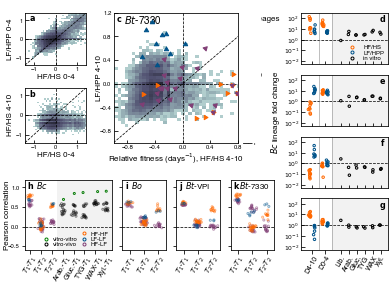

In [21]:


HF_mice, LF_mice = [DIET_MICE_MAP['HF'], DIET_MICE_MAP['LF']]
HLH_mice, LHL_mice = [DIET_MICE_MAP['HLH'], DIET_MICE_MAP['LHL']]
DIET_NAMES = {'HF':'HF/HS', 'LF':'LF/HPP'}

def savefig(fig, i):
    fig.savefig( f'{plot_dir}/presentation_figures/fig3_tradeoffs_v{i}.png' )
    return i+1
version = 1
### FIGURE 3 ###

norm = mpl.colors.LogNorm(0.1,3e3)
fig = plt.figure(figsize=(6.5, 4.5))

outer = mpl.gridspec.GridSpec(nrows=11, ncols=30,
                              height_ratios=[0.0, 0.0, 0.8, 1.1, 1.1, 1, 1.1, 1.1, 1, 2, 4.7],
                                width_ratios=[1,1,1,1,1,1,1,1,1,1,
                                              1,1,1,1,1,1,1,0.1,0.5,1,
                                              1,1,1,1,1,1,1,1,1,1], figure=fig)
bac = 'BWH2'

joint_ax = fig.add_subplot(outer[0:9, 0:20])
# joint_ax.set_xlabel('Relative fitness (/day)', fontsize=10, labelpad=12)
# joint_ax.set_ylabel('Relative fitness (/day)', fontsize=10, labelpad=12)
ax_methods.turn_off_ax(joint_ax)

for z, (m1_tuple, m2_tuple, plot_muller) in enumerate( [( (HF_mice, 0, 4), (LF_mice, 0, 4),  False),
                                           ( ([6,7], 0, 4), ([8, 9, 10], 4, 10), False ),
                                           ( (HF_mice, 4, 10), (LF_mice, 4, 10), True )] ):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple
    diet1, diet2 = mouse2diet[m1[0]], mouse2diet[m2[0]]
    xlabel = f'{DIET_NAMES[diet1]} {m1t1}-{m1t2}'
    ylabel = f'{DIET_NAMES[diet2]} {m2t1}-{m2t2}'

    if z == 0:
        ax = fig.add_subplot(outer[2:5, 0:5])
        ax.text(0.06, 0.84, '$\\bf{a}$', transform=ax.transAxes, fontsize=8)
        colorbar=False
    if z == 1:
        ax = fig.add_subplot(outer[6:9, 0:5])
        ax.text(0.06, 0.84, '$\\bf{b}$', transform=ax.transAxes, fontsize=8)
        colorbar=False
    if z < 2:
        # ax.set_xlim(-1.4, 1.4)
        # ax.set_ylim(-1.4, 1.4)
        ax.set_xlabel(xlabel, labelpad=2)
        ax.set_ylabel(ylabel, labelpad=2)
        # ticks = [-1, 0, 1]
        # tick_labels = ['-1', '0', '1']
        # ax.set_xticks( ticks, direction='in')
        # ax.set_yticks( ticks, direction='in')
        # ax.set_xticklabels( tick_labels )
        # ax.set_yticklabels( tick_labels )
    if z == 2:
        colorbar=True

        ax = fig.add_subplot(outer[2:9, 7:17])
        ax.set_xlabel('Relative fitness (days$^{-1}$), '+f'{xlabel}', labelpad=2)
        ax.set_ylabel(f'{ylabel}', labelpad=-3)
        ax.text(0.08, 0.92, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=10)
        ax.text(0.02, 0.93, '$\\bf{c}$', transform=ax.transAxes, fontsize=8)
    plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple,
                               norm=norm, colorbar=False, cmap=mpl.cm.bone_r, minfreq=10**-6.5, plot_muller=plot_muller)
    if z == 0:
        ax.set_xticks([-1.0, 0.0, 1.0])
        ax.set_yticks([-1.0, 0.0, 1.0])
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1.4, 1.4)
    if z == 1:
        ax.set_xticks([-1.0, 0.0, 1.0])
        ax.set_yticks([-1.0, 0.0, 1.0])
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1.4, 1.4)
    if z == 2:
        ax.set_xlim(-1.0, 0.8)
        ax.set_ylim(-1.0, 1.2)
        ax.set_xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
        ax.set_yticks([-0.8, -0.4, 0.0, 0.4, 0.8, 1.2])
    ax.tick_params(axis='both', labelsize=6)
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dashed', color='black')

if 'colorbar':
    colorbar_spec = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=(0.00, 1), subplot_spec=outer[2:9, 18])
    colorbar_ax = fig.add_subplot(colorbar_spec[1])
    _ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r, norm=norm)
    colorbar_ax.tick_params(axis='both', direction='out', labelsize=6, pad=0)
    # colorbar_ax.set_title('# lineages', fontsize=10)
    # colorbar_ax.set_ylabel('# lineages', fontsize=10, labelpad=8, rotation=-90)
    colorbar_ax.set_ylim(1, 3000)
    colorbar_ax.set_yticks([1, 10, 100, 1000])
    colorbar_ax.set_yticklabels(['1', '10', '100', '1k'])
    colorbar_ax.text(-0.1, 1.03, '# lineages', transform=colorbar_ax.transAxes)
    # colorbar_ax.text(0.33, 4, '# lineages', transform=colorbar_ax.transAxes, fontsize=10)


# if 'colorbar':
#     colorbar_ax = fig.add_subplot(outer[0, :20])
#     _ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r,
#         ticklocation='top', norm=norm, orientation='horizontal')
#     colorbar_ax.tick_params(axis='both', direction='out', labelsize=9, pad=-1)
#     # colorbar_ax.set_title('# lineages', fontsize=10)
#     # colorbar_ax.set_ylabel('# lineages', fontsize=10, labelpad=8, rotation=-90)
#     colorbar_ax.set_xlim(1, 3000)
#     colorbar_ax.set_xticks([1, 10, 100, 1000])
#     colorbar_ax.set_xticklabels(['1', '10', '100', '1000'])
#     colorbar_ax.text(0.33, 4, '# lineages', transform=colorbar_ax.transAxes, fontsize=10)

### tradeoff barcodes ####
tradeoff_examples_gs = mpl.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec = outer[2:, 23:])
bac, bc = 'BWH2', 'HL'

#[64411 11256 24875 77705  3826 45628 51865 83138 39395 72616]
bc_indices = [3826, 49450, 12504, 19507]
tradeoff_label_indices = {0: "$\\bf{d}$", 1: '$\\bf{e}$', 2: '$\\bf{f}$', 3:'$\\bf{g}$'}
for b, bc_index in enumerate(bc_indices):
    ax = fig.add_subplot(tradeoff_examples_gs[b])

    if True: ## formatting
        ax.text(0.98, 0.82, tradeoff_label_indices[b],
                horizontalalignment='right',transform=ax.transAxes)
        ax.set_yscale('log')
        ax.axhline(1, linestyle='dashed', color='black', zorder=0)
        ax.set_xlim(-1.4, 9.5)
        # ax.axvspan(-1.4, 1.9+0.7, color='white', alpha=0.1, linewidth=0)
        ax.axvline(0.8, color='grey', linewidth=0.5, alpha=1)
        ax.axvline(1.9+0.65, color='grey', linewidth=0.5, alpha=1)
        # ax.axvspan(-1.45, 2.4, color='grey', alpha=0.1, linewidth=0)
        # ax.axvspan(2.4, 4.0, color='orange', alpha=0.1)
        ax.axvspan(3.6-1.05, 10.5, color='grey', alpha=0.1, linewidth=0)
        ax.set_ylim(1/200, 300)
        ax.set_yticks([1/100, 1/10, 1, 10, 100], zorder=0)
        ax.set_yticklabels([r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$', r'$10^{2}$'])
        ax.tick_params(axis='y', labelsize=6)
        if b == 0:
            legend_markers = [ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec=DIET_COLORS['HF']),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec=DIET_COLORS['LF']),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec='black')
                              ]
            legend_labels = ['HF/HS', 'LF/HPP', 'in vitro']
            ax.legend(legend_markers, legend_labels,
                      loc=4, borderpad=0.1, labelspacing=0.05, columnspacing=0.1, frameon=False)
    if b < 3:
        # ax.set_xticks( [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] )
        ax.set_xticks( [0, 1.6, 3.6, 4.6, 5.6, 6.6, 7.6, 8.6] )
        ax.set_xticklabels([])
    if b == 1:
        ax.set_ylabel(f'{BAC_FORMAL_NAMES["BWH2"]} lineage fold change\t\t', labelpad=2, fontsize=8)
    if b == 3:
        ax.set_xticks( [0, 1.6, 3.6, 4.6, 5.6, 6.6, 7.6, 8.6] )
        # ax.set_xticklabels( ['HF D0-4', 'LF D0-4', 'HF D4-10', 'LF D4-10', 'Lib. prep',
        #                      'Arabinose', 'Glucose', 'TYG', 'WAX', 'Xylose'],
        #                     rotation=60)
        # ax.set_xticklabels( [r'HF $T_1$', r'LF $T_1$',
        #                      r'HF $T_2$', r'LF $T_2$',
        #                      r'HF $T_3$', r'LF $T_3$',
        #                      'Lib.', 'Arab.', 'Gluc.',
        #                      'TYG', 'WAX', 'Xyl.'],
        #                     rotation=60, fontsize=6, position=(0,0.05))
        ax.set_xticklabels( [r'D4-10', r'D0-4',
                             'Lib.', 'Arab.', 'Gluc.',
                             'TYG', 'WAX', 'Xyl.'],
                            rotation=60, fontsize=7, position=(0,0.02))
        ax.tick_params(axis='x', direction='out')

    plot_tradeoff_barcode_fold_changes(ax, bac, bc_index, cutoff=0)


##### strain correlations ####
strain_correlations_gs = mpl.gridspec.GridSpecFromSubplotSpec(1, 4, width_ratios=[2, 1, 1, 1], subplot_spec = outer[10, :21])
strain_correlations_ax = fig.add_subplot(outer[10, :21])
strain_correlations_ax.set_ylabel(r'Pearson correlation', labelpad=4)
ax_methods.turn_off_ax(strain_correlations_ax)

bac_index = {0:'$\\bf{h}$', 1:'$\\bf{i}$', 2:'$\\bf{j}$', 3:'$\\bf{k}$'}
for b, bac in enumerate(['BWH2', 'Bovatus', 'BtVPI', 'Bt7330']):
    bac_pairwise_correlations = bac_correlations[bac]
    ax = fig.add_subplot(strain_correlations_gs[b])
    s=4

    if bac == 'BWH2':
        correlation_sets = ['04vs04', '04vs410', '410vs410',
                            'Arabinose04', 'Glucose04', 'TYG04', 'WAX04', 'Xylose04']
        xlabels = [r'$T_1$-$T_1$', r'$T_1$-$T_2$', r'$T_2$-$T_2$',
                   r'Arab.-$T_1$', r'Gluc.-$T_1$', r'TYG-$T_1$', r'WAX-$T_1$', r'Xyl.-$T_1$']
        xticks = [1.2*i for i in range(len(correlation_sets))]
        ax.text(0.02, 0.88, bac_index[b], transform=ax.transAxes)
        ax.text(0.13, 0.88, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=8)
        ax.set_xlim([-0.6, 9])
    else:
        correlation_sets = ['04vs04', '04vs410', '410vs410']
        xlabels = [r'$T_1$-$T_1$', r'$T_1$-$T_2$', r'$T_2$-$T_2$']
        xticks = [1.2*i for i in range(len(correlation_sets))]
        ax.text(0.05, 0.88, bac_index[b], transform=ax.transAxes)
        ax.text(0.2, 0.88, BAC_FORMAL_NAMES[bac], transform=ax.transAxes,
                fontsize=8, horizontalalignment='left')
        ax.set_xlim([-0.6, 3])

    for i, correlation_set in enumerate(correlation_sets):
        if len(bac_pairwise_correlations[correlation_set]) == 2:
            within_diet, between_diet = bac_pairwise_correlations[correlation_set]
            ax.scatter( rnd.normal(scale=0.14, size=len(between_diet)) + i*1.2, between_diet, color='black', facecolor='none', s=s, alpha=0.5)
            ax.scatter( rnd.normal(scale=0.14, size=len(within_diet)) + i*1.2, within_diet, color='green', facecolor='none', s=s, alpha=1)
        if len(bac_pairwise_correlations[correlation_set]) == 3:
            within_HF_diet, within_LF_diet, between_diet = bac_pairwise_correlations[correlation_set]
            ax.scatter( rnd.normal(scale=0.14, size=len(between_diet)) + i*1.2, between_diet, color=DIET_COLORS['HLH'], facecolor='none', s=s, alpha=0.5)
            ax.scatter( rnd.normal(scale=0.14, size=len(within_HF_diet)) + i*1.2, within_HF_diet, color=DIET_COLORS['HF'], facecolor='none', s=s, alpha=0.5)
            ax.scatter( rnd.normal(scale=0.14, size=len(within_LF_diet)) + i*1.2, within_LF_diet, color=DIET_COLORS['LF'], facecolor='none', s=s, alpha=0.5)

    if True:
        if b > 0:
            ax.set_yticklabels([])
        # ax.set_title(BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=8)
        ax.set_ylabel('')
        ax.set_ylim(-0.6, 1.19)
        ax.set_yticks([-0.5, 0, 0.5, 1.0], zorder=0)
        ax.axhline(0, color='black', linestyle='dashed', zorder=0)
        ax.set_xticks(xticks, zorder=0)
        ax.set_xticklabels(xlabels, rotation=60, fontsize=7, position=(0,0.02))
        ax.axvspan(3, ax.get_xlim()[1], color='grey', alpha=0.1, linewidth=0)
        ax.tick_params(axis='both', direction='out')
        if bac == 'BWH2':
            legend_markers = [ax_methods.make_marker_obj(linewidth=0),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec='green'),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec='black'),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec=DIET_COLORS['HF']),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec=DIET_COLORS['LF']),
                              ax_methods.make_marker_obj(linewidth=0, marker='o', mfc='none', markersize=3, mec=DIET_COLORS['HLH'])
                              ]
            legend_labels = ['', 'vitro-vitro', 'vitro-vivo', 'HF-HF', 'LF-LF', 'HF-LF', ]
            ax.legend(legend_markers, legend_labels, ncol=2, loc=4,
                      borderpad=0.0, labelspacing=0.01,
                      columnspacing=0.1, handletextpad=.1,
                      frameon=False)


# fig.savefig(f'{biorxiv}/fig3_tradeoffs.pdf')